### Task description

Download the dataset and **perform RFM analysis**. In each sub-segment, divide the users into 4 classes.
Count the number of days that have passed since the last purchase, from the maximum purchase date in the dataset.

1. What is the maximum number of purchases made by one user?
2. What is the upper bound for the amount of purchases from users with class 4 in the M sub-segment? (In other words: users whose purchase amount is from 0 to X fall into the 4th class in the M sub-segment)
3. What is the lower bound for the number of purchases from users with class 1 in the F sub-segment?
4. What is the upper limit for the number of purchases from users with class 2 in the R sub-segment?
5. How many customers are in the 111 and 311 segments?
6. In which RFM segment is the largest and smallest number of users?

### Importing libraries

In [409]:
import pandas as pd
import numpy as np
import seaborn as sns
import researchpy as rp

### Uploading data and primary EDA

In [410]:
# uploading dataset for RFM with specifying columns data types
df = pd.read_csv('RFM_data.csv', parse_dates=['InvoiceDate'], dtype={'InvoiceNo': str,
                                                                     'CustomerCode': str,
                                                                     'Amount': float})

In [411]:
df.sample(n=5, random_state=0)

,InvoiceNo,CustomerCode,InvoiceDate,Amount
317141,D0471810300119,13168768,2020-09-30,481.60
304654,D0131810290013,13076290,2020-09-29,467.36
69552,D0801810060086,35074464,2020-09-06,490.00
53006,D0611810050045,13151142,2020-09-05,3223.48
308395,D0581810290409,19081432,2020-09-29,780.00


In [412]:
# Also let's rename all columns into more usefull snakecase like names
df = df.rename(columns={'InvoiceNo': 'invoice_no',
                        'CustomerCode': 'customer_code',
                        'InvoiceDate': 'invoice_date',
                        'Amount': 'amount'})

In [413]:
df.sample(n=5, random_state=0)

,invoice_no,customer_code,invoice_date,amount
317141,D0471810300119,13168768,2020-09-30,481.60
304654,D0131810290013,13076290,2020-09-29,467.36
69552,D0801810060086,35074464,2020-09-06,490.00
53006,D0611810050045,13151142,2020-09-05,3223.48
308395,D0581810290409,19081432,2020-09-29,780.00


In [414]:
df.shape

(332730, 4)

In [415]:
# Count missing values
df.isna().sum()

invoice_no       0
customer_code    0
invoice_date     0
amount           0
dtype: int64

In [416]:
# Also it may be usefull to look at min and max date in the dataframe
print(f'First date: {df["invoice_date"].min()}')
print(f'Last date: {df["invoice_date"].max()}')

First date: 2020-09-01 00:00:00
Last date: 2020-09-30 00:00:00


#### Count some basic descriptive statistics

In [417]:
unique_cust = df["customer_code"].nunique()
purchase_by_cust = round(df.shape[0] / df["customer_code"].nunique(), 2)
average_check = df["amount"].mean()

In [418]:
print(f'Numbers of unique customers: {unique_cust}')
print(f'Average amount of purchases by customer: {purchase_by_cust}')
print(f'Average check size: {round(average_check, 2)}')

Numbers of unique customers: 123733
Average amount of purchases by customer: 2.69
Average check size: 1239.03


### 1. What is the maximum number of purchases made by one user?

<AxesSubplot:>

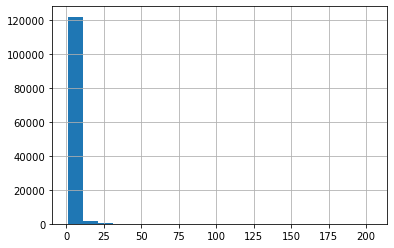

In [419]:
# Let's first look at overall distribution of the purchases number by customer
purchases_count = df['customer_code'].value_counts().reset_index()
purchases_count['customer_code'].hist(bins=20)

Not very informative. What we can say is that most customers made only sevaral purchases and there are some champions who made more than 20.  
In order to get more information let's split our data into groups and than build one more graph with distribution of these groups

In [420]:
purchases_count['bins'] = pd.cut(purchases_count['customer_code'], bins=[0, 1, 5, 20, 100, np.inf])

In [421]:
purchases_count['bins'].value_counts()

(1.0, 5.0]       58549
(0.0, 1.0]       52837
(5.0, 20.0]      12013
(20.0, 100.0]      331
(100.0, inf]         3
Name: bins, dtype: int64

<AxesSubplot:>

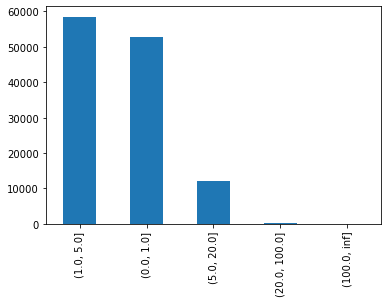

In [422]:
purchases_count['bins'].value_counts().plot(kind='bar')

Most customers made from 1 to 5 purchases, there are only 3 customers who made more than 100 purchases

In [423]:
# Now let's count the maximum purchases made by one customer
max_purchases_by_cust = df['customer_code'].value_counts().max()

In [424]:
print(f'Max amount by customer: {max_purchases_by_cust}')

Max amount by customer: 204


### 2. What is the upper bound for the amount of purchases from users with class 4 in the M sub-segment? (In other words: users whose purchase amount is from 0 to X fall into the 4th class in the M sub-segment)

In order to continue to work with the questions we will provide here the split by RFM groups.  
There are a lot of possible ways to make an RFM score and RFM bins, in this project I will provide the split by quantiles.
Here is the logic that will be behind the splitting:
- 0.00-0.25, 0.25-0.50, 0.50-0.75, 0.75-1.00 - will be the groups
- R - based on the diff between max date and last purchase
- M - based on the sum of all purchases
- F - based on the count of all purchases

Based on this data 1 will be given for the best indicators and 4 for the worst. For R less is better, for F and M - bigger is better 

In [425]:
df.sample(n=5, random_state=0)

,invoice_no,customer_code,invoice_date,amount
317141,D0471810300119,13168768,2020-09-30,481.60
304654,D0131810290013,13076290,2020-09-29,467.36
69552,D0801810060086,35074464,2020-09-06,490.00
53006,D0611810050045,13151142,2020-09-05,3223.48
308395,D0581810290409,19081432,2020-09-29,780.00


In [426]:
# Count the new column with diff between invoice_date and last date in the dataset
df['days_since_last_purchase'] = (df['invoice_date'].max() - df['invoice_date']).dt.days.astype(int)
df.sample(n=5, random_state=0)

,invoice_no,customer_code,invoice_date,amount,days_since_last_purchase
317141,D0471810300119,13168768,2020-09-30,481.60,0
304654,D0131810290013,13076290,2020-09-29,467.36,1
69552,D0801810060086,35074464,2020-09-06,490.00,24
53006,D0611810050045,13151142,2020-09-05,3223.48,25
308395,D0581810290409,19081432,2020-09-29,780.00,1


In [427]:
# Group the data by columns for RFM with corresponding agg functions
rfm_table = df.groupby('customer_code', as_index=False) \
                .agg({'amount': 'sum',
                      'invoice_date': 'count',
                      'days_since_last_purchase': 'min'})
rfm_table.head()

,customer_code,amount,invoice_date,days_since_last_purchase
0,02213019,1609.20,1,19
1,02213042,9685.48,3,22
2,02213071,415.00,1,29
3,02213088,305.00,1,23
4,02213092,1412.88,1,25


In [428]:
# With the help of qcut method we will made R M columns
rfm_table['m_score'] = pd.qcut(rfm_table['amount'], q=4, labels=[4, 3, 2, 1])
rfm_table['r_score'] = pd.qcut(rfm_table['days_since_last_purchase'], q=4, labels=[1, 2, 3, 4])

There is a problem with invoice date, as we know from the previous analysis most people are buying 1 product, so if we will use qcut() method fot this - people will receice their groups randomly, because amount of 1 in the whole dataset is too big  
Let's look at the amount of 1-10 in this data

In [429]:
rfm_table[['invoice_date']].query('invoice_date <= 10').value_counts()

invoice_date
1               52837
2               27577
3               15619
4                9491
5                5862
6                3834
7                2509
8                1622
9                1119
10                783
dtype: int64

<AxesSubplot:xlabel='invoice_date'>

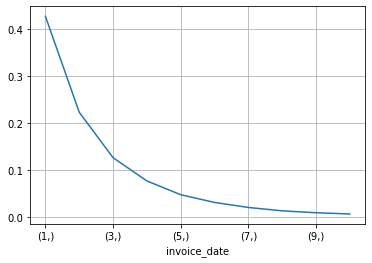

In [430]:
(rfm_table[['invoice_date']].query('invoice_date <= 10').value_counts() / rfm_table.shape[0]).plot(grid=True)

42% of our data equals to 1 - so splitting by quantiles is pretty pointless. Let's look at data one more time in order to give more logical splitting

<AxesSubplot:>

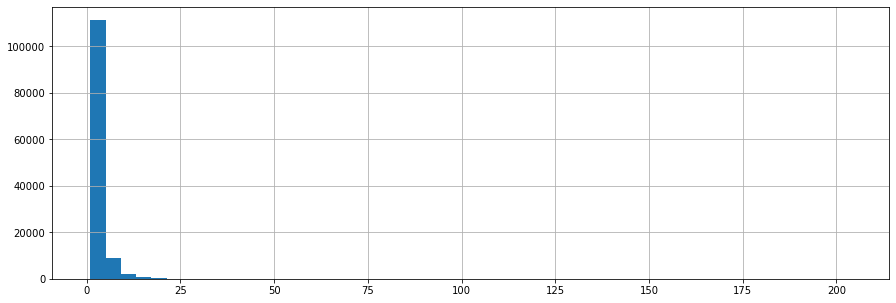

In [431]:
rfm_table['invoice_date'].hist(bins=50, figsize=(15, 5))

So what conclusions we can make now:
- 42% made only 1 purchase
- Only several customers made more than 20 purchases
- After 4 purchases we see that the graph is pretty flat

So I will make next split:
[0:1], [2:4], [5:20], [20:inf]

We will make it with the help of cut() method:

In [432]:
rfm_table['f_score'] = pd.cut(rfm_table['invoice_date'], bins=[0, 1, 4, 20, np.inf], labels=[4, 3, 2, 1])

In [433]:
# Table with all scores
rfm_table.sample(n=5, random_state=0)

,customer_code,amount,invoice_date,days_since_last_purchase,m_score,r_score,f_score
25661,13120031,70.00,1,19,4,4,4
62697,14018178,1190.00,1,14,3,3,4
13529,13051775,4087.42,1,27,1,4,4
31094,13144508,325.00,1,25,4,4,4
4292,13000765,3262.44,5,2,2,1,2


In [434]:
rfm_table.dtypes

customer_code                 object
amount                       float64
invoice_date                   int64
days_since_last_purchase       int32
m_score                     category
r_score                     category
f_score                     category
dtype: object

Our score are category dtype, that's is not very convenient for our purposes, so let's change them into string

In [435]:
rfm_table.dtypes

customer_code                 object
amount                       float64
invoice_date                   int64
days_since_last_purchase       int32
m_score                     category
r_score                     category
f_score                     category
dtype: object

In [436]:
rfm_table['r_score'] = rfm_table['r_score'].astype(int)
rfm_table['f_score'] = rfm_table['f_score'].astype(int)
rfm_table['m_score'] = rfm_table['m_score'].astype(int)

In [437]:
# Combining all scores into one RFM-score
rfm_table['rfm_score'] = rfm_table['r_score'].map(str) + rfm_table['f_score'].map(str) + rfm_table['m_score'].map(str)

In [438]:
rfm_table.sample(n=5, random_state=0)

,customer_code,amount,invoice_date,days_since_last_purchase,m_score,r_score,f_score,rfm_score
25661,13120031,70.00,1,19,4,4,4,444
62697,14018178,1190.00,1,14,3,3,4,343
13529,13051775,4087.42,1,27,1,4,4,441
31094,13144508,325.00,1,25,4,4,4,444
4292,13000765,3262.44,5,2,2,1,2,122


Now we can go further and give answers to other questions.  
The second one was to indicate the upper bound for the amount of purchases from users with class 4 in the M sub-segment

In [439]:
rfm_table.query('m_score == 4')['amount'].max()

765.0

### 3. What is the lower bound for the number of purchases from users with class 1 in the F sub-segment?

In [440]:
rfm_table.query('f_score == 1')['invoice_date'].min()

21

### 4. What is the upper bound for the number of purchases from users with class 2 in the R sub-segment?

In [441]:
rfm_table.query('r_score == 2')['invoice_date'].max()

49

### 5. How many customers are in the 111 and 311 segments?

In [442]:
# Let's look more close into RFM data
rfm_table.sample(n=5, random_state=0)

,customer_code,amount,invoice_date,days_since_last_purchase,m_score,r_score,f_score,rfm_score
25661,13120031,70.00,1,19,4,4,4,444
62697,14018178,1190.00,1,14,3,3,4,343
13529,13051775,4087.42,1,27,1,4,4,441
31094,13144508,325.00,1,25,4,4,4,444
4292,13000765,3262.44,5,2,2,1,2,122


In [443]:
cust_by_score = rfm_table.groupby('rfm_score')['customer_code'].count().reset_index() \
    .rename(columns={'customer_code': 'cnt'})

cust_by_score.sample(5)

,rfm_score,cnt
50,443,6729
24,242,1722
27,311,2
41,421,124
8,133,3743


In [444]:
cust_by_score.query('rfm_score in("111", "311")')

,rfm_score,cnt
0,111,312
27,311,2


The amount of most active customers is 312

### 6. Which RFM segments have the largest and lowest number of users?

In [445]:
cust_by_score[cust_by_score['cnt'] == cust_by_score['cnt'].max()]

,rfm_score,cnt
51,444,10624


Most customers are more or less passive, that is expected

In [446]:
cust_by_score[cust_by_score['cnt'] == cust_by_score['cnt'].min()]

,rfm_score,cnt
1,112,2
27,311,2
40,411,2


As for the lowest number: we can interpret it in the way that it is very uncommon for the customer to be in the very different groups.